In [1]:
import math
import random
import matplotlib.pyplot as plt
%matplotlib inline

from collections import defaultdict
from glob import glob

In [2]:
glob("data/*")

['data/TEXTEN1.txt',
 'data/eng-input.txt',
 'data/dictionary.txt',
 'data/test_data.tsv',
 'data/training_data.tsv',
 'data/TEXTCZ1.txt']

In [3]:
with open("data/TEXTEN1.txt", "r") as f:
    text_en = f.read()

with open("data/TEXTCZ1.txt", "r", encoding="iso8859_2") as f:
    text_cz = f.read()

In [4]:
s = "haf haf nuf haf olaf haf nuf olaf olaf haf".split(" ")
len(list(zip(s, s[1:])))

9

In [5]:
from collections import Counter

In [6]:
sum(dict(Counter(s)).values())

10

In [29]:
def perturb(text, p):
    alphabet = list(set(text_en) - set(["\n"]))
    
    return "".join([c
                    if (random.random() > p or c == "\n")
                    else random.choice(alphabet)
                    for c in text])

In [30]:
text_en[:40].replace("\n", " "), perturb(text_en[:40], 1).replace("\n", " ")

('WHEN on board H . M . S . Beagle as natu',
 'KwN5 R, ptZew u d K D k H BWrrHB 4K j)Yl')

In [31]:
def text_entropy(text, plot=False):
    words = text.split("\n")
    
    c_1 = Counter(words)
    c_2 = Counter(zip(words, words[1:]))
    c_3 = Counter(zip(words, words[1:], words[2:]))
    
    total_c1 = sum(c_1.values())
    total_c2 = sum(c_1.values())
    
    p_1 = {word: float(count) / total_c1 for word, count in c_1.items()}
    p_2 = {word: float(count) / total_c2 for word, count in c_2.items()}
    
    if plot:
        print(sorted(c_1.values())[-100:])
        plt.plot(np.log(list(sorted(c_1.values()))))
        plt.show()
        plt.plot(np.log(list(sorted(set(c_1.values())))))
        plt.show()

    p_2c = dict()
    
    for key in c_2.keys():
        i, j = key

        if c_1[i] == 0:
            p_2c[key] = 0
        else:
            p_2c[key] = float(p_2[key]) / p_1[i]

            
    cond_entropy = 0

    for key in c_2.keys():
        if key in p_2c:
            cond_entropy -= p_2[key] * math.log2(p_2c[key])

#     cond_entropy = -sum([p_1[key] * math.log2(p_1[key]) for key in p_1.keys()])
            
    perplexity = 2 ** cond_entropy

    return cond_entropy, perplexity

In [32]:
text_entropy(text_en)

(5.287460725971182, 39.055686806417654)

In [33]:
text_entropy(perturb(text_en, 1))

(1.600694391811237, 3.032892560655091)

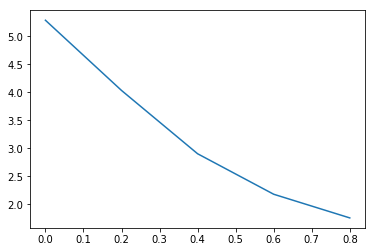

In [34]:
X = np.arange(0, 1, step=0.2)
ents = [text_entropy(perturb(text_en, e)) for e in X]
plt.plot(X, [a for a, b in ents])

In [27]:
text_entropy("he he he he".replace(" ", "\n"))

(-0.0, 1.0)

In [28]:
text_entropy("a b c d".replace(" ", "\n"))

(2.0, 4.0)

In [15]:
s = perturb(text_en, 1)

In [16]:
c = Counter(perturb(text_en, 1).split("\n"))

In [17]:
sorted(c.items(), key=lambda x: x[1], reverse=True)[:100]

[('!', 447),
 ('G', 426),
 ('L', 420),
 ('s', 416),
 ('J', 413),
 ('C', 406),
 ('q', 405),
 ("'", 404),
 ('&', 401),
 ('H', 400),
 (';', 399),
 ('F', 397),
 ('c', 396),
 ('N', 393),
 ('v', 391),
 ('V', 391),
 ('n', 391),
 ('1', 391),
 ('?', 391),
 ('T', 389),
 ('g', 389),
 (')', 389),
 ('O', 389),
 ('u', 388),
 ('E', 388),
 ('2', 387),
 ('9', 386),
 ('7', 385),
 ('x', 384),
 ('X', 384),
 ('B', 384),
 ('I', 384),
 ('o', 383),
 ('.', 383),
 ('p', 383),
 ('8', 383),
 ('/', 382),
 ('m', 382),
 ('h', 382),
 ('P', 380),
 ('j', 380),
 (',', 380),
 ('U', 379),
 ('f', 379),
 ('d', 378),
 ('5', 378),
 ('l', 377),
 ('Q', 375),
 ('Y', 374),
 ('a', 373),
 ('W', 372),
 ('D', 372),
 (':', 371),
 ('k', 369),
 ('i', 368),
 ('y', 368),
 ('Z', 366),
 ('M', 365),
 ('K', 365),
 ('3', 364),
 ('A', 364),
 ('r', 363),
 ('4', 363),
 ('6', 363),
 ('e', 360),
 ('w', 360),
 ('(', 358),
 ('b', 356),
 ('"', 355),
 ('0', 354),
 ('z', 353),
 ('t', 352),
 ('R', 349),
 ('S', 330),
 ('du', 21),
 ('eI', 21),
 ('7P', 18),